In [1]:
bond_dim=24
iLayer=30

path_dir='./data/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)
path_dir_layers='./data/layers/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)


filename1=path_dir+'hotrg_gilt_X{0}.pth'.format(bond_dim)
filename2=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}.pth'.format(bond_dim,iLayer)


In [2]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from LTRG import get_scaling_dimensions_from_spectrum
from HOTRG import forward_observable_tensors, forward_layer
from TNModels import Ising2D
from tqdm.auto import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [3]:
print('loading coarse-grained tensors...')

loaded_dict=torch.load(filename1,map_location=device)
options,params,layers,Ts,logTotals=loaded_dict['options'],loaded_dict['params'],loaded_dict['layers'],loaded_dict['Ts'],loaded_dict['logTotals']

loading coarse-grained tensors...


In [27]:
print('loading lTRG eigenvectors...')

options1,s_ltrg,u_ltrg=torch.load(filename2,map_location=device)
scd_ltrg=get_scaling_dimensions_from_spectrum(s_ltrg.abs(),scaling=2)
scd_ltrg_labels=[f'{x:.3f}' for x in scd_ltrg]
print(scd_ltrg)

loading lTRG eigenvectors...
tensor([0.0000, 0.1275, 1.0021, 1.1264, 1.1446, 1.9981, 2.0008, 2.0033, 2.0447,
        2.1197, 2.1987, 2.2031, 2.5010, 2.6845, 2.6845, 2.7911, 2.8228, 2.8264,
        2.8480, 2.8480, 3.0153, 3.0953, 3.1057, 3.1057, 3.1173, 3.1173, 3.1612,
        3.1612, 3.2012, 3.2012, 3.2065, 3.2251])


In [15]:
u_ltrg_inv=torch.linalg.pinv(u_ltrg).T.conj()
u_ltrg_useit_dualbasis=u_ltrg_inv

In [23]:

def show_overlap_ltrg(v_op,title='',ax=None,k=32,xtick=True,ytick=True):
    if ax is None:
        plt.figure(figsize=(6,2))
    else:
        plt.sca(ax)
    plt.title(title)
    plt.grid(axis='x',color='k',alpha=.2,zorder=0,linestyle='--')

    v_op=v_op.flatten().to(torch.complex128)
    #overlap=u_ltrg_inv.T.conj()@v_op
    #overlap=u_ltrg.T.conj()@v_op
    overlap=u_ltrg_useit_dualbasis.T.conj()@v_op
    barHeight=overlap.abs().cpu().numpy()
    barAngle=np.angle(overlap.cpu().numpy())
    barSign=np.sign(overlap.real.cpu().numpy())
    plt.bar(range(k),barHeight[:k],color=plt.cm.hsv(barAngle[:k]/(2*np.pi))*[.7,.7,.7,1],zorder=3)
    # label the scdim on the biggest bar
    biggest_idx=np.argmax(barHeight)
    # plt.text(biggest_idx,barHeight[biggest_idx],'$\Delta=$'+scd_ltrg_labels[biggest_idx],ha='center',va='bottom',fontsize=12)
    # constraint the text to be inside the figure
    text_x=np.clip(biggest_idx,2,k-3)
    plt.text(text_x,barHeight[biggest_idx],'$\Delta=$'+scd_ltrg_labels[biggest_idx],ha='center',va='bottom',fontsize=12)


    if xtick: 
        plt.xlabel('Eigenvectors')
        plt.xticks(range(k),['']*k)
        # plt.xticks(range(k),scd_ltrg_labels[:k],rotation=75)
    else: 
        plt.xticks(range(k),['']*k)
    if ytick:
        plt.ylabel('Overlap')
    else: 
        plt.yticks([])
    # plt.xlim(-2,k-1+2)
    # plt.ylim(0,1.25)
    plt.axhline(0,color='k')
    # add grid

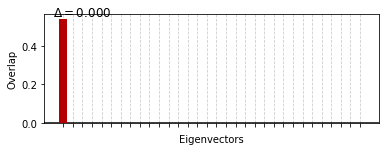

In [24]:
show_overlap_ltrg(Ts[iLayer])

layer 6
bias norm 6 0.09846972936775815


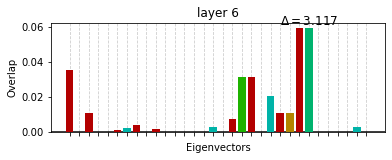

layer 8
bias norm 8 0.04747485883305487


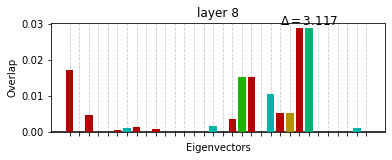

layer 10
bias norm 10 0.025222786615276313


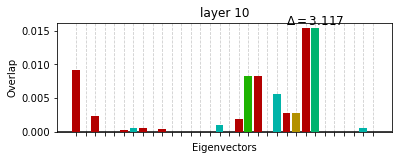

layer 12
bias norm 12 0.014052276680008831


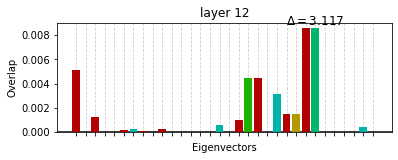

layer 14
bias norm 14 0.00800471404781271


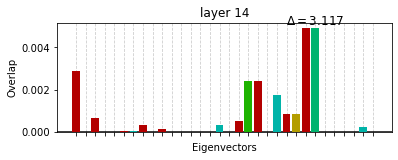

layer 16
bias norm 16 0.004592167953521484


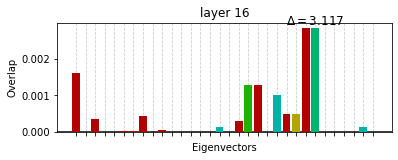

layer 18
bias norm 18 0.002641518825766774


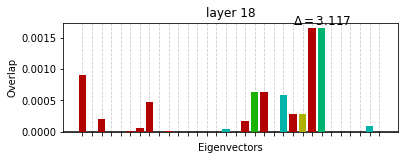

layer 20
bias norm 20 0.0015228755345550753


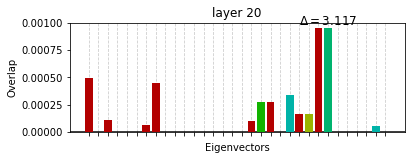

layer 22
bias norm 22 0.0008829652997442588


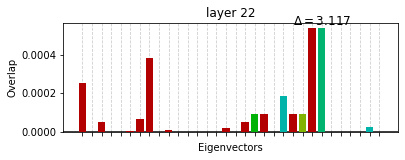

layer 24
bias norm 24 0.0005139773524829864


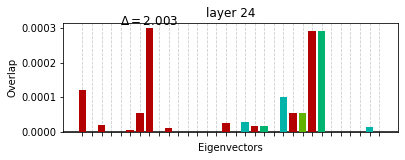

layer 26
bias norm 26 0.0002889216262942908


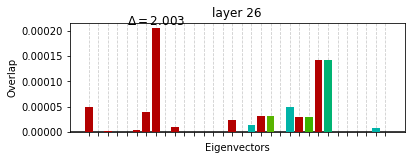

layer 28
bias norm 28 0.00013148327251784976


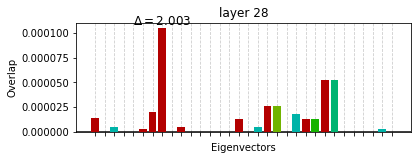

layer 30
bias norm 30 9.522664539767498e-17


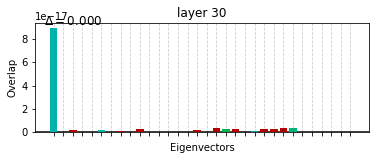

layer 32
bias norm 32 0.0001265075247846095


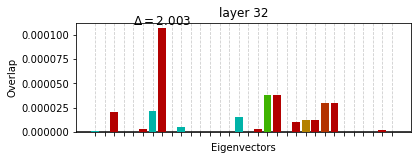

layer 34
bias norm 34 0.00026239734911570167


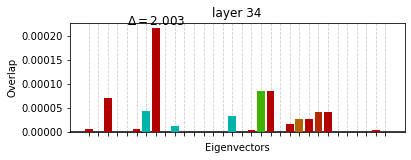

layer 36
bias norm 36 0.00043184925823720933


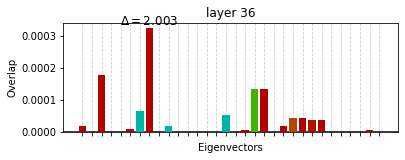

layer 38
bias norm 38 0.0006959777098152333


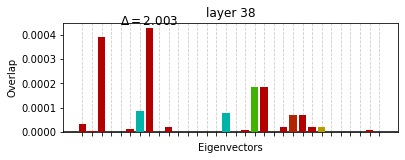

layer 40
bias norm 40 0.0011972146975851388


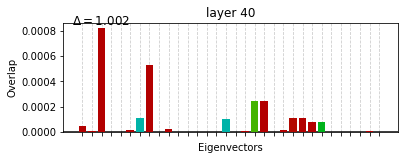

layer 42
bias norm 42 0.002222908073451693


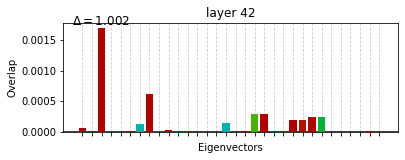

layer 44
bias norm 44 0.004324124786011333


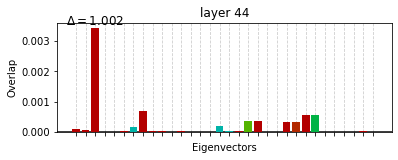

layer 46
bias norm 46 0.00857855988503522


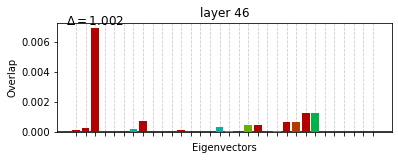

layer 48
bias norm 48 0.01713303297080874


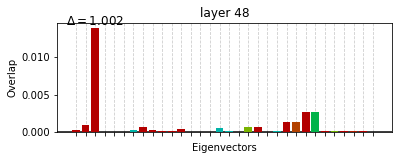

layer 50
bias norm 50 0.03430515492576574


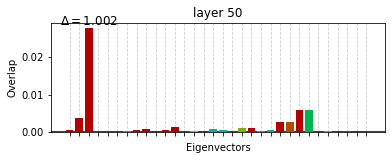

layer 52
bias norm 52 0.06902419229100935


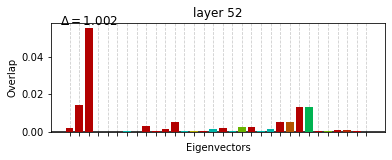

layer 54
bias norm 54 0.32095560967994025


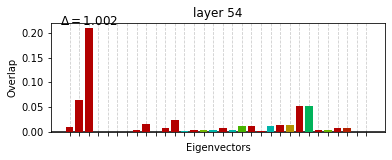

layer 56
bias norm 56 0.35297514118489637


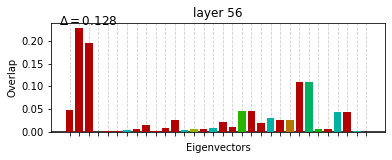

layer 58
bias norm 58 0.8092367689544753


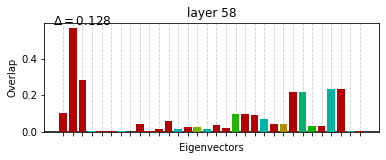

layer 60
bias norm 60 0.8617971165986499


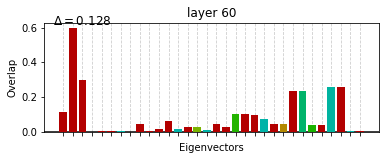

In [25]:
Tfix=Ts[iLayer].flatten()
for i in range(0,len(Ts),2):
    if Ts[i].shape==Ts[iLayer].shape:
        Tbias=Ts[i].flatten()
        Tbias=Tbias-(Tbias@Tfix)*Tfix/Tfix.norm()**2
        print(f'layer {i}')
        print(f'bias norm {i} {Tbias.norm()}')
        show_overlap_ltrg(Tbias,title=f'layer {i}')
        plt.show()
